오토인코더 예제 변형 (noise 잡음 강도를 늘려가면서 확인하기)

In [72]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm 
import numpy as np

In [73]:
EPOCH = 10
BATCH_SIZE = 64
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda"if USE_CUDA else "cpu")
print("Using Device:", DEVICE)

Using Device: cuda


In [74]:
trainset = datasets.FashionMNIST(
    root = './.data/',
    train = True,
    download = True,
    transform = transforms.ToTensor()
)
train_loader = torch.utils.data.DataLoader(
    dataset = trainset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = 2
)

In [75]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,12),
            nn.ReLU(),
            nn.Linear(12,3),
        )
        self.decoder = nn.Sequential(
            nn.Linear(3,12),
            nn.ReLU(),
            nn.Linear(12,64),
            nn.ReLU(),
            nn.Linear(64,128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [76]:
autoencoder = Autoencoder().to(DEVICE)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.005)
criterion = nn.MSELoss()

In [77]:
view_data = trainset.data[:5].view(-1, 28*28)
view_data = view_data.type(torch.FloatTensor)/255.

In [78]:
def train(autoencoder, train_loader):
    autoencoder.train()
    for step, (x, label) in enumerate(train_loader):
        x = x.view(-1, 28*28).to(DEVICE)
        y = x.view(-1, 28*28).to(DEVICE)
        label = label.to(DEVICE)

        encoded,decoded = autoencoder(x)

        loss = criterion(decoded, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [79]:
for epoch in range(1, EPOCH+1):
    train(autoencoder, train_loader)

    test_x = view_data.to(DEVICE)
    _,decoded_data = autoencoder(test_x)

0.0


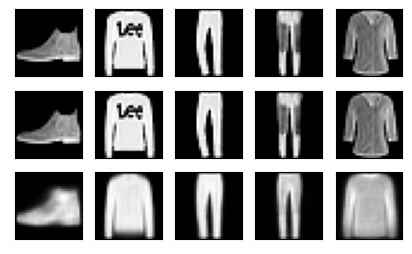

0.1


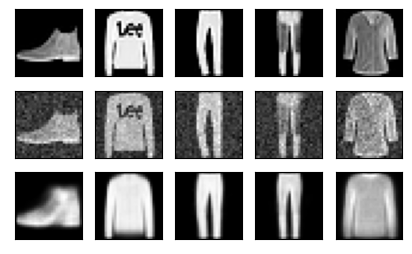

0.2


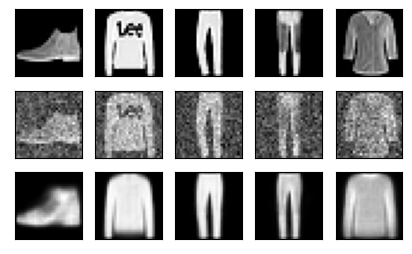

0.30000000000000004


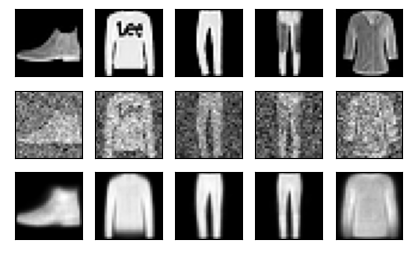

0.4


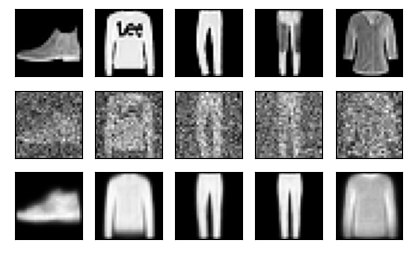

0.5


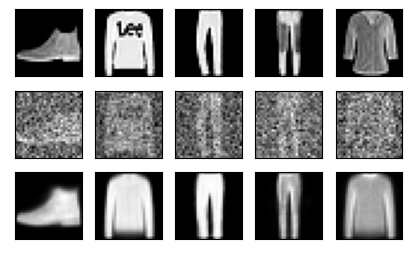

0.6


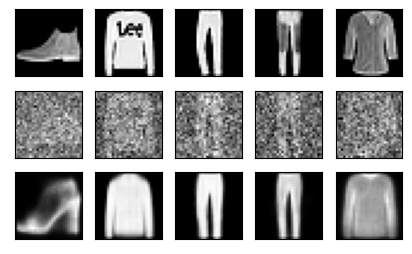

0.7


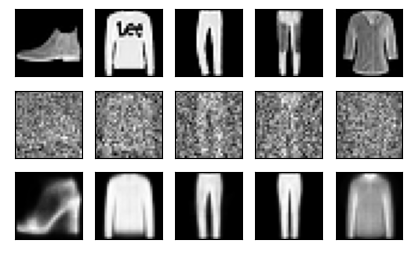

0.7999999999999999


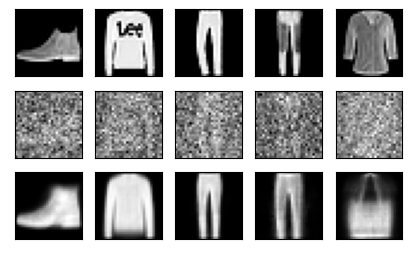

0.8999999999999999


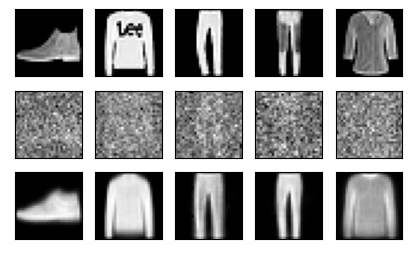

0.9999999999999999


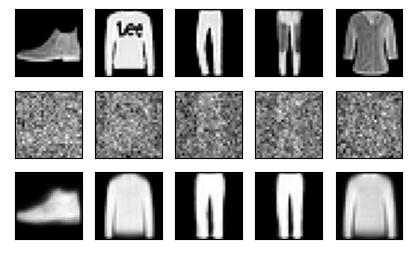

1.0999999999999999


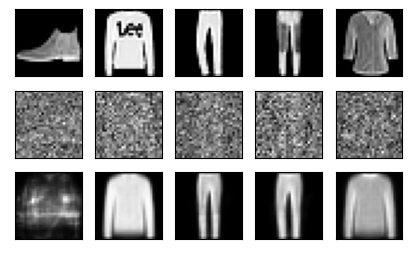

1.2


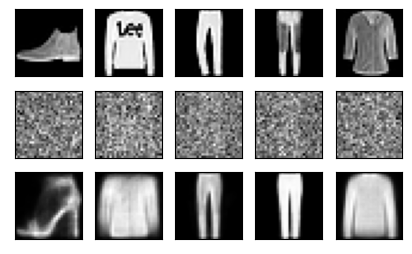

1.3


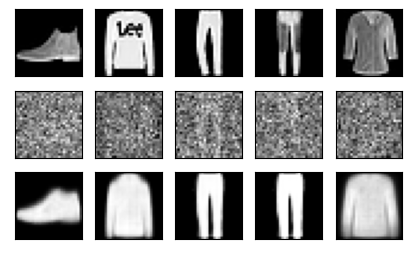

1.4000000000000001


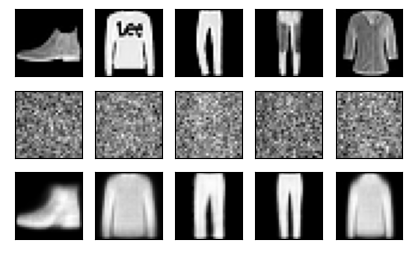

1.5000000000000002


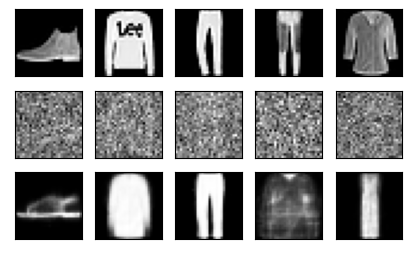

1.6000000000000003


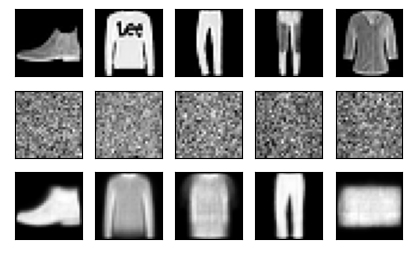

1.7000000000000004


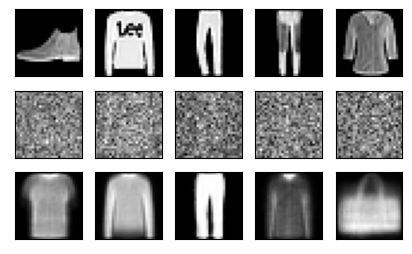

1.8000000000000005


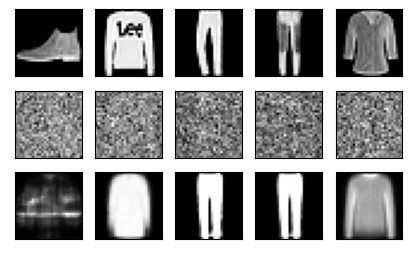

1.9000000000000006


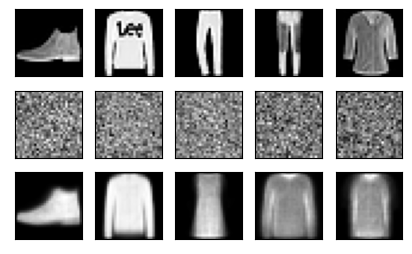

In [86]:
noise_num=0.0
while noise_num <= 2.0:
    
    def add_noise(img):
        noise = torch.randn(img.size())*noise_num

        noisy_img = img + noise
        return noisy_img

    def train(autoencoder, train_loader):
        autoencoder.train()
        avg_loss = 5
        for step, (x, label) in enumerate(train_loader):
            noisy_x = add_noise(x)
            noisy_x = noisy_x.view(-1, 28*28).to(DEVICE)
            y = x.view(-1, 28*28).to(DEVICE)

            label = label.to(DEVICE)
            encoded, decoded = autoencoder(noisy_x)

            loss = criterion(decoded, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            avg_loss += loss.item()
        return avg_loss / len(train_loader)

    testset = datasets.FashionMNIST(
        root = './.data/',
        train = False,
        download = True,
        transform = transforms.ToTensor()
    )

    sample_data = testset.data[:5].view(-1, 28*28)
    sample_data = sample_data.type(torch.FloatTensor)/255.

    original_x = sample_data[:5]
    noisy_x = add_noise(original_x).to(DEVICE)
    _, recovered_x =  autoencoder(noisy_x)

    f, a = plt.subplots(3, 5, figsize=(5,3))

    for i in range(5):
        original_img = np.reshape(original_x.to("cpu").data.numpy()[i], (28,28))
        a[0][i].imshow(original_img, cmap='gray')
        a[0][i].set_xticks(()); a[0][i].set_yticks(())

    for i in range(5):
        noisy_img =  np.reshape(noisy_x.to("cpu").data.numpy()[i], (28,28))
        a[1][i].imshow(noisy_img, cmap='gray')
        a[1][i].set_xticks(()); a[1][i].set_yticks(())

    for i in range(5):
        recovered_img = np.reshape(recovered_x.to("cpu").data.numpy()[i], (28,28))
        a[2][i].imshow(recovered_img, cmap='gray')
        a[2][i].set_xticks(()); a[2][i].set_yticks(())

    print(noise_num)
    plt.show()
    noise_num = noise_num + 0.1
